# Temporal Fusion Transformer: Time Series Forecasting with Deep Learning

Source: https://towardsdatascience.com/temporal-fusion-transformer-time-series-forecasting-with-deep-learning-complete-tutorial-d32c1e51cd91/

## What is Temporal Fusion Transformer?

Temporal Fusion Transformer (TFT) is a Transformer-based model that leverages self-attention to capture the complex temporal dynamics of multiple time sequences.

TFT supports:

- Multiple time series: We can train a TFT model on thousands of univariate or multivariate time series.
- Multi-Horizon Forecasting: The model outputs multi-step predictions of one or more target variables – including prediction intervals.
- Heterogeneous features: TFT supports many types of features, including time-variant and static exogenous variables.
- Interpretable predictions: Predictions can be interpreted in terms of variable importance and seasonality.

## The Extended Time-Series Data Format
Among notable DL time-series models, TFT stands out because it supports various types of features. These are:

- Time-varying known
- Time-varying unknown
- Time-invariant real
- Time-invariant categorical

For example, imagine we have a sales forecasting case:

Let’s say we have to predict the sales of 3 products. The num sales is the target variable. The CPI index or the number of visitors are time-varying unknown features because they are only known up to prediction time. However, holidays and special days are time-varying known events.

The product id is a time-invariant (static) categorical feature. Other features which are numerical and not time-dependent such as yearly_revenue can be categorized as time-invariant real.

Before moving to our project, we will first show a mini-tutorial on how to convert your data to the extended time-series format.


## The TimeSeriesDataSet Function

For this tutorial, we use the [TemporalFusionTransformer](https://arxiv.org/pdf/1912.09363.pdf) model from the PyTorch Forecasting library and PyTorch Lightning:

pip install torch==2.0.1+cu118 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0

The whole process involves 3 things:

- Create a pandas dataframe with our time-series data.
- Wrap our dataframe into a TimeSeriesDataset instance.
- Pass our TimeSeriesDataset instance to [TemporalFusionTransformer](https://arxiv.org/pdf/1912.09363.pdf).

The TimeSeriesDataset is very useful because it helps us specify whether features are time-varying or static. Plus, it’s the only format that [TemporalFusionTransformer](https://arxiv.org/pdf/1912.09363.pdf) accepts.

Let’s create a minimal training dataset to show how TimeSeriesDataset works:

In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet

sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


The most important column of our dataframe is the time_idx – it determines the sequence of samples. If there are no missing observations, the values should increase by +1 for each time-series.

Next, we wrap our dataframe into a TimeSeriesDataset instance:

In [2]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

All arguments are self-explanatory: The max_encoder_length defines the lookback period and max_prediction_length specifies how many datapoints will be predicted. In our case, we look back 2 time steps in the past to output 3 predictions.

The TimeSeriesDataset instance now serves as a dataloader. Let’s print a batch and check how our data will be passed to TFT:

In [3]:
# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[1, 2]])
tensor([[0]])


tensor([[3, 4, 5]])


This batch contains the training values [0,1] from the first time-series (group 0) and the testing values[2,3,4]. If you rerun this code, you will get different values because the data are shuffled by default.

# Day Ahead Prices Forecasting

Here, we use Day Ahead Price Time Series. This dataset contains hourly Day Ahead prices for Germany/Luxemburg [€/MWh] between 01-10-2018 and 14-05-2025.

We do data preprocessing according to [3]:

- Create new features : month, day, hour and day_of_week.

Let’s start:

In [4]:
data = pd.read_csv('../data/DAprices_201810010000_202505140000_hourly.csv', index_col=0, sep=';', decimal=',')
#data['Datum von'] = pd.to_datetime(data['Datum von'], dayfirst=True)
data.index = pd.to_datetime(data.index, dayfirst=True)
data.sort_index(inplace=True)
data.replace(0., np.nan)
data

,Deutschland/Luxemburg [€/MWh] Originalauflösungen
Datum von,
2018-10-01 00:00:00,59.53
2018-10-01 01:00:00,56.10
2018-10-01 02:00:00,51.41
2018-10-01 03:00:00,47.38
2018-10-01 04:00:00,47.59
...,...
2025-05-13 19:00:00,151.07
2025-05-13 20:00:00,223.58
2025-05-13 21:00:00,148.96


Now, we prepare our dataset for the TimeSeriesDataset format. 

In [5]:
df_list = []
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
data=data[['Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
# Forward fill missing values
data = data.ffill()

# Handle remaining infinite values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.ffill()

ts = data['Deutschland/Luxemburg [€/MWh] Originalauflösungen']

start_date = min(ts.fillna(method='ffill').dropna().index)
end_date = max(ts.fillna(method='bfill').dropna().index)

tmp = pd.DataFrame({'DAprices': data['Deutschland/Luxemburg [€/MWh] Originalauflösungen']})
date = date = tmp.index

active_range = (ts.index >= start_date) & (ts.index <= end_date)
ts = ts[active_range].fillna(0.)

tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
  
tmp['days_from_start'] = (date - earliest_time).days
  
#     #tmp['days_from_start'] = (date - earliest_time).days
tmp['date'] = date
tmp['zone'] = 'Deutschland/Luxemburg [€/MWh] Originalauflösungen'
tmp['hour'] = date.hour
tmp['day'] = date.day
tmp['day_of_week'] = date.dayofweek
tmp['month'] = date.month

#     #stack all time series vertically
df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()


C:\Users\Anwender\AppData\Local\Temp\ipykernel_7236\3861399626.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)
C:\Users\Anwender\AppData\Local\Temp\ipykernel_7236\3861399626.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)


In [6]:
time_df

,DAprices,hours_from_start,days_from_start,date,zone,hour,day,day_of_week,month
26304,90.00,26304,1096,2021-10-01 00:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,0,1,4,10
26305,71.39,26305,1096,2021-10-01 01:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,1,1,4,10
26306,59.98,26306,1096,2021-10-01 02:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,2,1,4,10
26307,47.94,26307,1096,2021-10-01 03:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,3,1,4,10
26308,54.52,26308,1096,2021-10-01 04:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,4,1,4,10
...,...,...,...,...,...,...,...,...,...
32299,218.04,32299,1345,2022-06-07 19:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,19,7,1,6
32300,227.46,32300,1345,2022-06-07 20:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,20,7,1,6
32301,228.81,32301,1345,2022-06-07 21:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,21,7,1,6
32302,220.26,32302,1345,2022-06-07 22:00:00,Deutschland/Luxemburg [€/MWh] Originalauflösungen,22,7,1,6


The time_df is now in the proper format for the TimeSeriesDataset. As you have guessed by now, since the granularity is hourly, the hours_from_start variable will be the time index.

## Exploratory Data Analysis

Text(0, 0.5, 'DA Price [€/MWh]')

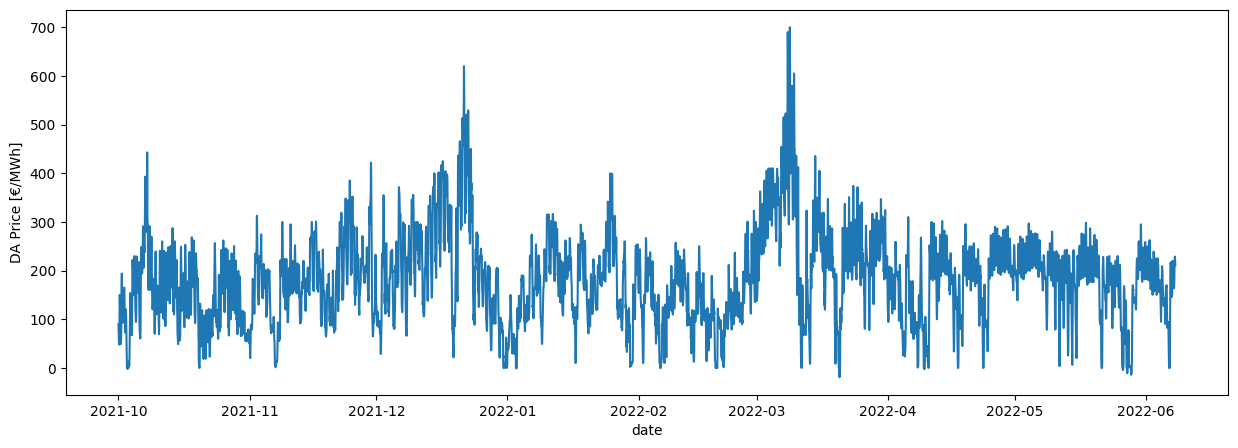

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,5])
plt.plot(time_df['date'],time_df['DAprices'])
plt.xlabel('date')
plt.ylabel('DA Price [€/MWh]')

There is no noticeable trend. We can further experiment and check stationarity, signal decompositions, and so on, but in our case, we focus on the model-building aspect only.

Also, notice that other time-series forecasting methods like ARIMA must satisfy a few requirements (for instance, the time-series must first become stationary.) With TFT, we can leave our data as-is.

## Create DataLoaders

In this step, we pass our time_df to the TimeSeriesDataSet format which is immensely useful because:

- It spares us from writing our own Dataloader.
- We can specify how TFT will handle the dataset’s features.
- We can normalize our dataset with ease. In our case, normalization is mandatory because all time sequences differ in magnitude. Thus, we use the GroupNormalizer to normalize each time-series individually.
- Our model uses a lookback window of one week (7*24) to predict the Day Ahead prices of the next 24 hours.

Also, notice that the hours_from_start is both the time index and a time-varying feature. The power_usage is our target variable. For the sake of demonstration, our validation set is the last day:

In [11]:
from pytorch_forecasting import GroupNormalizer
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 3*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="DAprices",
    group_ids=["zone"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["zone"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['DAprices'],
    target_normalizer=GroupNormalizer(
       groups=["zone"], transformation=None#"softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


## Baseline Model
Next, the step that almost everyone forgets: A baseline model. Especially in time-series forecasting, you will be surprised at how often a naive predictor outperforms even a fancier model!

As a naive baseline, we predict the Day Ahead prices of the previous day:

In [12]:
import torch
from pytorch_forecasting import BaseModel, MAE, Baseline

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cpu")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

# ➢25.139617919921875

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


26.44999885559082

## Training the Temporal Fusion Transformer Model
We can train our TFT model using the familiar Trainer interface from PyTorch Lightning.

Notice the following things:

- We use the EarlyStopping callback to monitor the validation loss.
- We use Tensorboard to log our training and validation metrics.
- Our model uses Quantile Loss – a special type of loss that helps us output the prediction intervals. For more on the Quantile Loss function, check this article.
- We use 4 attention heads, like the original paper.
- We are now ready to build and train our model:

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [14]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor(logging_interval='step')  
#logger = TensorBoardLogger("lightning_logs")  

trainer = Trainer(
    max_epochs=2,
    accelerator='cpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback])

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 3.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 734 K  | tr

Epoch 0: 100%|██████████| 93/93 [01:31<00:00,  1.02it/s, v_num=3, train_loss_step=23.50, val_loss=14.70, train_loss_epoch=30.80]

Metric val_loss improved. New best score: 14.708


Epoch 1: 100%|██████████| 93/93 [01:33<00:00,  0.99it/s, v_num=3, train_loss_step=19.00, val_loss=11.60, train_loss_epoch=21.60]

Metric val_loss improved by 3.131 >= min_delta = 0.0001. New best score: 11.577
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 93/93 [01:34<00:00,  0.99it/s, v_num=3, train_loss_step=19.00, val_loss=11.60, train_loss_epoch=21.60]


## Load and Save the Model

In [15]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\TimeSeriesTransformer\notebooks\lightning_logs\version_3\checkpoints\epoch=1-step=186.ckpt


Don’t forget to save your model. Although we can pickle it, the safest option is to save the best epoch directly:

In [50]:
import re
match = re.search(r'version_(.*)\\', best_model_path)
if match:
    print(match.group(1)[0])  # Output: 2

0


In [17]:
!zip -r model.zip lightning_logs/*

updating: lightning_logs/version_0/00093/ (164 bytes security) (stored 0%)
updating: lightning_logs/version_0/00093/zone/ (164 bytes security) (stored 0%)
updating: lightning_logs/version_0/00093/zone/metadata.tsv (164 bytes security) (stored 0%)
updating: lightning_logs/version_0/00093/zone/tensors.tsv (164 bytes security) (stored 0%)
updating: lightning_logs/version_0/checkpoints/ (164 bytes security) (stored 0%)
updating: lightning_logs/version_0/checkpoints/epoch=0-step=93.ckpt (164 bytes security) (deflated 8%)
updating: lightning_logs/version_0/events.out.tfevents.1747663015.U7512-03.18988.9 (164 bytes security) (deflated 11%)
updating: lightning_logs/version_0/hparams.yaml (164 bytes security) (deflated 89%)
updating: lightning_logs/version_0/projector_config.pbtxt (164 bytes security) (deflated 35%)
updating: lightning_logs/version_3/00186/ (164 bytes security) (stored 0%)
updating: lightning_logs/version_3/00186/zone/ (164 bytes security) (stored 0%)
updating: lightning_logs/v

To load the model again, unzip model.zip and execute the following – just remember the best model path:

In [34]:
from pytorch_forecasting import TemporalFusionTransformer
#load our saved model again
!unzip model.zip
best_model_path='lightning_logs/version_2/checkpoints/epoch=0-step=93.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


## Model Evaluation
Get predictions on the validation set and calculate the average P50 (quantile median) loss:

In [35]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cpu')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

#6.067104816436768
#tensor([ 1.0064,  6.8266,  2.1732,  8.3614, 11.9679], device='cuda:0')

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


19.996423721313477
tensor([19.9964])


## Plot Predictions on Validation Data
If we pass the mode=raw on the predict() method, we get more information, including predictions for all seven quantiles. We also have access to the attention values (more about that later).

Take a closer look at the raw_predictions variable:

In [36]:

#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 24, 7])


We use the _plotprediction() to create our plots. Of course, you could make your own custom plot – the _plotprediction() has the extra benefit of adding the attention values.

Note: Our model predicts the next 24 datapoints in one go. This is not a rolling forecasting scenario where a model predicts a single value each time and ‘stitches’ all predictions together.

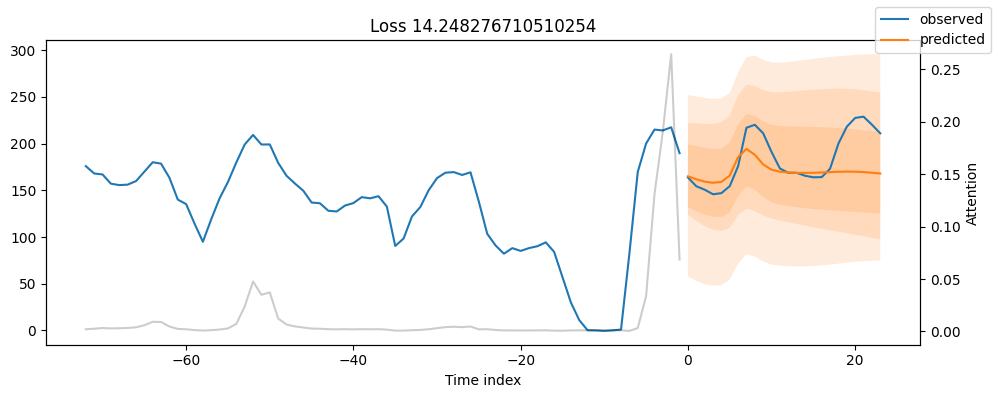

In [37]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
    plt.xlabel('time step')
    #plt.ylabel('Day Ahead Price')


The results are quite impressive.

Our Temporal Fusion Transformer model was able to capture the behaviour of te time-series, in terms of both seasonality and magnitude!

Also, notice that:

- We did not perform any hyperparameter tuning.
- We did not implement any fancy feature engineering technique.
In a subsequent section, we show how to improve our model with hyperparameter optimization.

## Out-of-Sample Forecasts
Let’s create out-of-sample predictions, beyond the final datapoint of validation data.

All we have to do is to create a new dataframe that contains:

- The number of N=max_encoder_length past dates, which act as the lookback window – the encoder data in TFT terminology.
- The future dates of size max_prediction_length for which we want to compute our predictions – the decoder data.

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


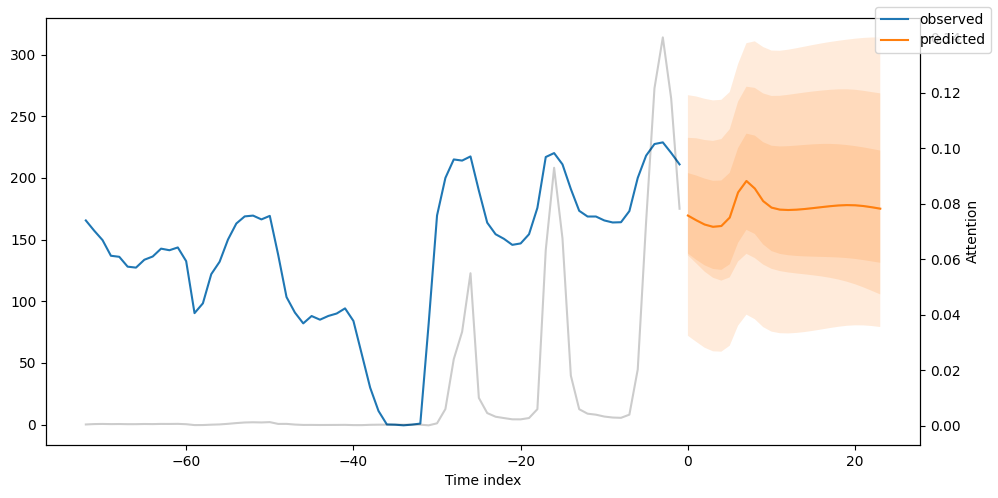

In [38]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints

encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length*consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns

decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query("zone == 'Deutschland/Luxemburg [€/MWh] Originalauflösungen'")
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False, ax=ax);


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

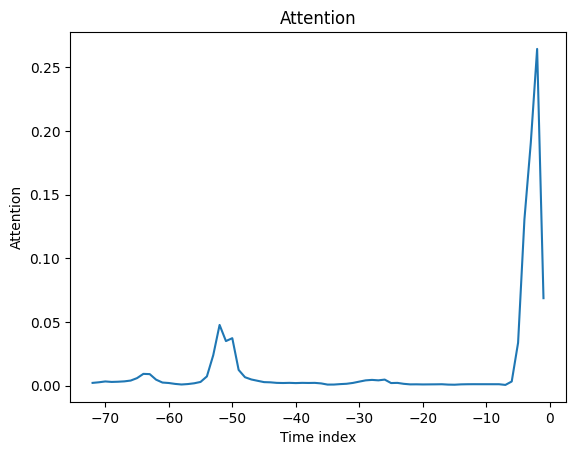

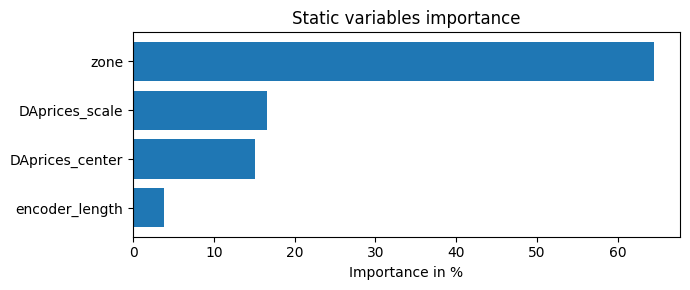

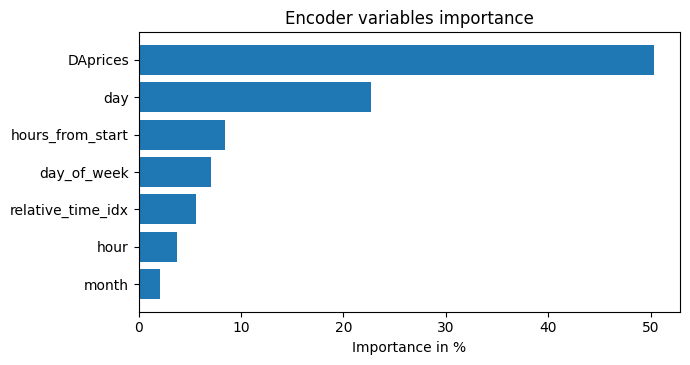

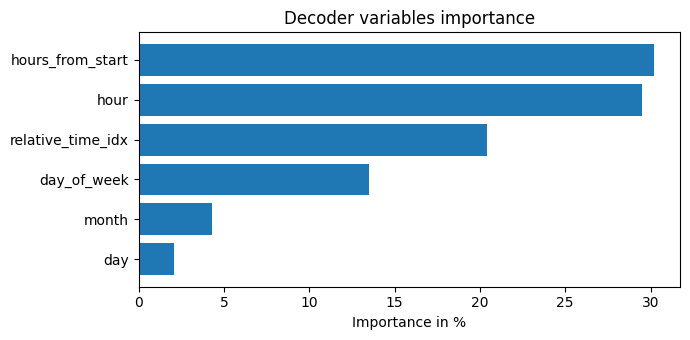

In [39]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)